# Import

In [1]:
# https://medium.com/swlh/fine-tuning-gpt-2-for-magic-the-gathering-flavour-text-generation-3bafd0f9bb93

In [2]:
!pip install transformers

In [3]:
import pandas as pd
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoTokenizer, AutoModelWithLMHead

import numpy as np
import random
import torch
from torch.utils.data import Dataset, DataLoader

from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup

from tqdm import tqdm, trange
import torch.nn.functional as F
import csv

import os
import gc

import re

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Get data

In [4]:
sonets_list = os.listdir('drive/MyDrive/poems/sonety') 

sonety_str = ''
for i, s in enumerate(sonets_list):
    ### Prepare data
    with open(f'drive/MyDrive/poems/sonety/{s}', 'r') as f:
        sonety_str = sonety_str + f.read().replace('\u2009', ' ') + '\n\n\n\n\n\n'

#     df = df[df['poem'].apply(lambda x: len(x.split(' ')) < 350)]

sonety = []
for s in sonety_str.split('\n\n\n\n\n'):
    if len(s) > 0:
        s_clean = s.strip('\n').strip() 
        if '\n\n\n\n' in s_clean:
            s_clean = s_clean.replace('\n\n', '\n').replace('\n\n', '\n')
        s_clean = s_clean.replace('\n ', '\n').replace('\n', ' ').replace('...', '.')
        s_clean = re.sub('\[[0-9]+\]', '', s_clean)
        s_clean = re.sub('[,;\(\)]', '', s_clean)
        sonety.append(s_clean)
len(sonety)

24

In [5]:
with open(f'drive/MyDrive/poems/pantadeusz/pantadeusz.txt', 'r') as f:
    pan_str = f.read()

pantadeusz = []
for p in pan_str.split('\n\n'):
    if len(p.split('\n')) > 3:        
        pantadeusz.append(p.strip())
len(pantadeusz)

743

In [6]:
#Get the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('flax-community/papuGaPT2',
                                          bos_token='<|startoftext|>', 
                                          eos_token='<|endoftext|>', 
                                          pad_token='<|pad|>')

# model = AutoModelWithLMHead.from_pretrained('flax-community/papuGaPT2')

# #Accumulated batch size (since GPT2 is so big)
# def pack_tensor(new_tensor, packed_tensor, max_seq_len):
#     if packed_tensor is None:
#         return new_tensor, True, None
#     if new_tensor.size()[1] + packed_tensor.size()[1] > max_seq_len:
#         return packed_tensor, False, new_tensor
#     else:
#         packed_tensor = torch.cat([new_tensor, packed_tensor[:, 1:]], dim=1)
#         return packed_tensor, True, None

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [7]:
max_flavour = max([len(tokenizer.encode(s)) for s in sonety])

print(f'The longest flavour text is {max_flavour} tokens long.')

The longest flavour text is 173 tokens long.


In [8]:
class Poems(Dataset):  
    def __init__(self, txt_list, tokenizer, max_length=max_flavour):
        super().__init__()

        self.tokenizer = tokenizer
        self.poems = []
        self.attn_masks = []

        for s in tqdm(txt_list):
            encodings_dict = tokenizer('<|startoftext|>'+ s + '<|endoftext|>', 
                                    truncation=True, 
                                    max_length=max_length, 
                                    padding="max_length")
            
            self.poems.append(torch.tensor(encodings_dict['input_ids']))
            self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
            
        self.poems_count = len(self.poems)
        
    def __len__(self):
        return self.poems_count

    def __getitem__(self, idx):
        return self.poems[idx], self.attn_masks[idx] 

In [9]:
from torch.utils.data import random_split

dataset = Poems(pantadeusz, tokenizer, max_length=max_flavour)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

f'There are {train_size} samples for training, and {val_size} samples for validation testing'

100%|██████████| 743/743 [00:00<00:00, 1401.93it/s]


'There are 668 samples for training, and 75 samples for validation testing'

In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

bs=8

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), # Sampling for training is random
            batch_size = bs
        )

validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), # Sampling for validation is sequential as the order doesn't matter.
            batch_size = bs 
        )

In [11]:
import random
from transformers import GPT2LMHeadModel, GPT2Config
import numpy as np

# Loading the model configuration and setting it to the GPT2 standard settings.
configuration = GPT2Config.from_pretrained('flax-community/papuGaPT2', output_hidden_states=False)

# Create the instance of the model and set the token size embedding length
model = AutoModelWithLMHead.from_pretrained("flax-community/papuGaPT2", config=configuration)
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# This step is optional but will enable reproducible runs.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:925: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


In [12]:
# We wil create a few variables to define the training parameters of the model
# epochs are the training rounds
# the warmup steps are steps at the start of training that are ignored
# every x steps we will sample the model to test the output

epochs = 5
warmup_steps = 1e2
sample_every = 100

In [13]:
from transformers import AdamW
# AdamW is a class from the huggingface library, it is the optimizer we will be using, and we will only be instantiating it with the default parameters. 
optimizer = AdamW(model.parameters(),
                  lr = 5e-4,
                  eps = 1e-8
                )

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [14]:
from transformers import get_linear_schedule_with_warmup

"""
Total training steps is the number of data points, times the number of epochs. 
Essentially, epochs are training cycles, how many times each point will be seen by the model. 
"""

total_steps = len(train_dataloader) * epochs

"""
We can set a variable learning rate which will help scan larger areas of the 
problem space at higher LR earlier, then fine tune to find the exact model minima 
at lower LR later in training.
"""
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [15]:
import random
import time
import datetime

def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    print(f'Beginning epoch {epoch_i + 1} of {epochs}')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every 100 batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print(f'Batch {step} of {len(train_dataloader)}. Loss:{batch_loss}. Time:{elapsed}')

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print(f'Example output: {tokenizer.decode(sample_output, skip_special_tokens=True)}')
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print(f'Average Training Loss: {avg_train_loss}. Epoch time: {training_time}')

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids,  
                             attention_mask = b_masks,
                             labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print(f'Validation loss: {avg_val_loss}. Validation Time: {validation_time}')

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print(f'Total training took {format_time(time.time()-total_t0)}')

Beginning epoch 1 of 5
Average Training Loss: 17.18990289881116. Epoch time: 0:00:34
Validation loss: 3.731582593917847. Validation Time: 0:00:01
Beginning epoch 2 of 5
Average Training Loss: 3.224682262965611. Epoch time: 0:00:36
Validation loss: 3.412528157234192. Validation Time: 0:00:01
Beginning epoch 3 of 5
Average Training Loss: 2.711837398154395. Epoch time: 0:00:34
Validation loss: 3.410639190673828. Validation Time: 0:00:01
Beginning epoch 4 of 5
Average Training Loss: 2.3145634219759987. Epoch time: 0:00:35
Validation loss: 3.576548171043396. Validation Time: 0:00:01
Beginning epoch 5 of 5
Average Training Loss: 1.9690138371217818. Epoch time: 0:00:35
Validation loss: 3.806069254875183. Validation Time: 0:00:01
Total training took 0:03:00


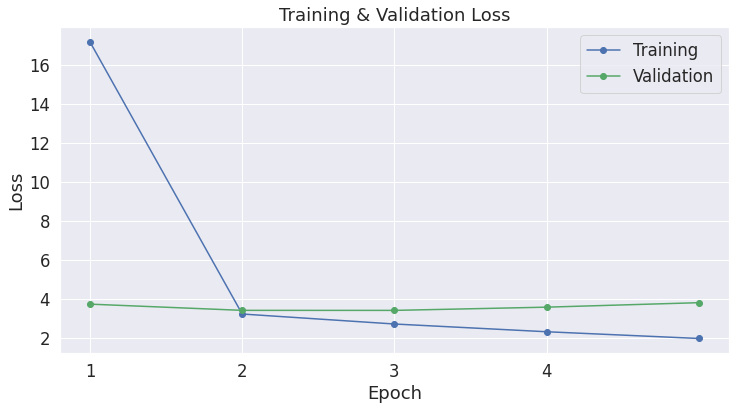

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [19]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

sample_outputs = model.generate(
                                generated, 
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0: Po chwili do izb pospólstwa, z których na czele
Tadeusz z Telimeną rozmawiali,
Podniosły Tadeusz ganek z Telimeną i Zosię,
Rozprzestrzenił nieco jej wodze,
Wzdłuż szepce coś o jej rywalce i o żołnierzu,
Tadeusz nie był w porę czy umyślnie zajęty rozmową,
Czyżby to, co mówił, zaraz zmilczał.


1: Tu Wojski zobaczył, był na stołkach,
Na nim posadził Horeszków, pany z Soplicowskim
Sędzia na to rzekł: «Nie dosyć zuchwale,
Już mnie uszczupliło wasze zuchwale wasze,
Upomnię się o wasze dusze, jeśli mi o tym powiecie.
Ja wam opowiem, co was czeka. Wszak wy jesteście
Przebudzeniem!»


2: Sędzia za stół ławą nalała, lecz już brała księże.
Widać, iż kucharka nadzwyczaj gospodarna.
Rzekł Sędzia: Klucznik, że w domu tym pan Sopliców wiele
Odbył, więc o jego gospodarskim rodzie wieść nie śmie
Może? Wszak tam na wielkiej sali siedzi jego dość bogata rodzina!
Może pan Hrabia, brat jego stryja, pan Dobrzyńscy,
Niemalże wszyscy, gdy się z panem Horeszkowskim ustąpili
I zaczęli do siebie strzelać: ws